In [2]:
from __future__ import annotations

import os
import io
import math
import json
import random
from dataclasses import dataclass
from typing import Callable, Iterable, Optional, Sequence, Tuple, Union

import numpy as np

try:
    import torch
    from torch.utils.data import Dataset
except ImportError:  # fail-soft: позволим использовать без torch
    torch = None
    class Dataset:  # минимальный заглушечный класс
        pass

try:
    from scipy.spatial.transform import Rotation as SciPyRotation
except Exception:  # SciPy не обязателен
    SciPyRotation = None
















usage: colab_kernel_launcher.py [-h] [--out OUT] [--n_per_class N_PER_CLASS]
                                [--n_points N_POINTS] [--sphere_surface]
                                [--cube_surface] [--noise_std NOISE_STD]
                                [--random_rotate]
                                [--random_scale_lo RANDOM_SCALE_LO]
                                [--random_scale_hi RANDOM_SCALE_HI]
                                [--random_translate RANDOM_TRANSLATE]
                                [--export_npy_folder EXPORT_NPY_FOLDER]
                                [--export_ply_folder EXPORT_PLY_FOLDER]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-ffda61ea-3927-4991-96ab-26c969593122.json


SystemExit: 2

In [3]:
# =============================================================
#  Геометрический сэмплинг
# =============================================================

def _rand_normals(n: int) -> np.ndarray:
    """Сэмплинг n 3D-векторов с нормальным распределением и нормализацией до единичной длины."""
    v = np.random.normal(size=(n, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True) + 1e-12
    return v


def sample_sphere(
    n_points: int,
    radius: float = 1.0,
    surface: bool = True,
) -> np.ndarray:
    """Сэмплирует точки на поверхности или внутри 3D-сферы.

    Аргументы:
        n_points: количество точек.
        radius: радиус сферы.
        surface: если True — поверхность; если False — равномерно по объёму.

    Возврат:
        np.ndarray формы (n_points, 3).
    """
    dirs = _rand_normals(n_points)  # направления
    if surface:
        r = np.full((n_points, 1), radius, dtype=np.float32)
    else:
        # равномерно по объёму: радиус^3 ~ U(0, R^3)
        u = np.random.rand(n_points, 1)
        r = radius * (u ** (1.0 / 3.0))
    pts = dirs * r
    return pts.astype(np.float32)


def sample_cube(
    n_points: int,
    half_extent: float = 1.0,
    surface: bool = True,
) -> np.ndarray:
    """Сэмплирует точки на поверхности или в объёме осевого куба [-h, h]^3."""
    if surface:
        # Сэмплируем равномерно по каждой грани.
        pts = np.zeros((n_points, 3), dtype=np.float32)
        faces = np.random.randint(0, 6, size=n_points)  # 6 граней
        # Координаты U,V на грани
        uv = np.random.rand(n_points, 2) * 2 * half_extent - half_extent
        for i in range(n_points):
            f = faces[i]
            u, v = uv[i]
            if f == 0:  # +X
                pts[i] = [half_extent, u, v]
            elif f == 1:  # -X
                pts[i] = [-half_extent, u, v]
            elif f == 2:  # +Y
                pts[i] = [u, half_extent, v]
            elif f == 3:  # -Y
                pts[i] = [u, -half_extent, v]
            elif f == 4:  # +Z
                pts[i] = [u, v, half_extent]
            elif f == 5:  # -Z
                pts[i] = [u, v, -half_extent]
    else:
        pts = np.random.rand(n_points, 3).astype(np.float32) * 2 * half_extent - half_extent
    return pts.astype(np.float32)

In [4]:
_rand_normals(3)

array([[-0.27031151,  0.94589181, -0.17950036],
       [-0.64317612, -0.75203772,  0.14409631],
       [ 0.6703791 , -0.3967051 ,  0.62707012]])

In [5]:
# =============================================================
#  Аугментации
# =============================================================

def random_rotation_matrix() -> np.ndarray:
    """Возвращает случайную 3x3 ортонормированную матрицу вращения."""
    if SciPyRotation is not None:
        return SciPyRotation.random().as_matrix().astype(np.float32)
    # Fallback: метод на основе случайного кватерниона
    u1, u2, u3 = np.random.rand(3)
    q1 = math.sqrt(1 - u1) * math.sin(2 * math.pi * u2)
    q2 = math.sqrt(1 - u1) * math.cos(2 * math.pi * u2)
    q3 = math.sqrt(u1) * math.sin(2 * math.pi * u3)
    q4 = math.sqrt(u1) * math.cos(2 * math.pi * u3)
    q = np.array([q1, q2, q3, q4], dtype=np.float32)
    # кватернион -> матрица вращения
    x, y, z, w = q
    R = np.array([
        [1 - 2*(y*y + z*z), 2*(x*y - z*w),     2*(x*z + y*w)],
        [2*(x*y + z*w),     1 - 2*(x*x + z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w),     2*(y*z + x*w),     1 - 2*(x*x + y*y)],
    ], dtype=np.float32)
    return R


def apply_rotation(points: np.ndarray, R: np.ndarray) -> np.ndarray:
    return (points @ R.T).astype(np.float32)


def apply_scale(points: np.ndarray, scale: float) -> np.ndarray:
    return (points * scale).astype(np.float32)


def apply_translation(points: np.ndarray, t: np.ndarray) -> np.ndarray:
    return (points + t.reshape(1, 3)).astype(np.float32)


def apply_noise(points: np.ndarray, noise_std: float) -> np.ndarray:
    if noise_std <= 0:
        return points
    noise = np.random.normal(scale=noise_std, size=points.shape).astype(np.float32)
    return (points + noise).astype(np.float32)

In [6]:
# =============================================================
#  Генерация одной выборки (одного облака) по классу
# =============================================================

def gen_cloud_for_class(
    class_id: int,
    n_points: int,
    sphere_surface: bool = True,
    cube_surface: bool = True,
    sphere_radius: float = 1.0,
    cube_half_extent: float = 1.0,
    noise_std: float = 0.0,
    random_rotate: bool = False,
    random_scale_range: Optional[Tuple[float, float]] = None,
    random_translate_range: Optional[float] = None,
) -> np.ndarray:
    """Генерирует одно облако точек для указанного класса."""
    if class_id == 0:  # sphere
        pts = sample_sphere(n_points, radius=sphere_radius, surface=sphere_surface)
    elif class_id == 1:  # cube
        pts = sample_cube(n_points, half_extent=cube_half_extent, surface=cube_surface)
    else:
        raise ValueError(f"Неизвестный class_id={class_id}, ожидается 0 или 1.")

    # Аугментации
    if random_rotate:
        R = random_rotation_matrix()
        pts = apply_rotation(pts, R)

    if random_scale_range is not None:
        lo, hi = random_scale_range
        scale = np.random.uniform(lo, hi)
        pts = apply_scale(pts, scale)

    if random_translate_range is not None:
        tr = np.random.uniform(-random_translate_range, random_translate_range, size=(3,)).astype(np.float32)
        pts = apply_translation(pts, tr)

    pts = apply_noise(pts, noise_std)
    return pts


# =============================================================
#  Полная генерация массива точек и меток
# =============================================================

def generate_arrays(
    n_per_class: int,
    n_points: Union[int, Tuple[int, int]] = 1024,
    sphere_surface: bool = True,
    cube_surface: bool = True,
    sphere_radius: float = 1.0,
    cube_half_extent: float = 1.0,
    noise_std: float = 0.0,
    random_rotate: bool = False,
    random_scale_range: Optional[Tuple[float, float]] = None,
    random_translate_range: Optional[float] = None,
    shuffle: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    """Генерирует *два* класса по n_per_class облаков и возвращает (X, y).

    X: массив формы (N_clouds, max_points, 3) или (N_clouds, n_points, 3) если фиксирован.
       Если `n_points` — диапазон, то будет паддинг до максимума и дополнительный массив `lengths`.
    y: метки (N_clouds,).

    NB: Для простоты основной путь — фиксированное число точек. Для переменной длины используйте
    функцию `generate_variable_length` ниже.
    """
    if isinstance(n_points, tuple):
        raise ValueError(
            "Для переменного числа точек используйте generate_variable_length или передайте int в n_points."
        )
    total = 2 * n_per_class
    X = np.zeros((total, n_points, 3), dtype=np.float32)
    y = np.zeros((total,), dtype=np.int64)

    idx = 0
    for cls in (0, 1):
        for _ in range(n_per_class):
            X[idx] = gen_cloud_for_class(
                cls,
                n_points,
                sphere_surface=sphere_surface,
                cube_surface=cube_surface,
                sphere_radius=sphere_radius,
                cube_half_extent=cube_half_extent,
                noise_std=noise_std,
                random_rotate=random_rotate,
                random_scale_range=random_scale_range,
                random_translate_range=random_translate_range,
            )
            y[idx] = cls
            idx += 1

    if shuffle:
        perm = np.random.permutation(total)
        X = X[perm]
        y = y[perm]
    return X, y


def generate_variable_length(
    n_per_class: int,
    n_points_range: Tuple[int, int] = (512, 2048),
    **kwargs,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Генерирует облака переменного размера. Возвращает (X_pad, y, lengths).

    *X_pad*: паддированный массив формы (N_clouds, max_points, 3).
    *lengths*: истинное число точек в каждом облаке.
    """
    lo, hi = n_points_range
    lengths = [np.random.randint(lo, hi + 1) for _ in range(2 * n_per_class)]
    max_len = max(lengths)
    X = np.zeros((2 * n_per_class, max_len, 3), dtype=np.float32)
    y = np.zeros((2 * n_per_class,), dtype=np.int64)

    idx = 0
    for cls in (0, 1):
        for _ in range(n_per_class):
            n_pts = lengths[idx]
            pts = gen_cloud_for_class(cls, n_pts, **kwargs)
            X[idx, :n_pts] = pts
            y[idx] = cls
            idx += 1

    perm = np.random.permutation(len(lengths))
    X = X[perm]
    y = y[perm]
    lengths = np.asarray(lengths, dtype=np.int64)[perm]
    return X, y, lengths

In [7]:
# =============================================================
#  Torch Dataset-ы
# =============================================================

@dataclass
class AugmentCfg:
    noise_std: float = 0.0
    random_rotate: bool = False
    random_scale_range: Optional[Tuple[float, float]] = None
    random_translate_range: Optional[float] = None

    def apply(self, pts: np.ndarray) -> np.ndarray:
        if self.random_rotate:
            pts = apply_rotation(pts, random_rotation_matrix())
        if self.random_scale_range is not None:
            lo, hi = self.random_scale_range
            scale = np.random.uniform(lo, hi)
            pts = apply_scale(pts, scale)
        if self.random_translate_range is not None:
            tr = np.random.uniform(-self.random_translate_range, self.random_translate_range, size=(3,))
            pts = apply_translation(pts, tr)
        pts = apply_noise(pts, self.noise_std)
        return pts


class SyntheticPointCloudDataset(Dataset):
    """PyTorch-совместимый датасет синтетических облаков точек.

    Возвращает кортеж `(points, label)`, где:
      * `points`: torch.FloatTensor формы (N, 3)
      * `label`: torch.LongTensor скаляр
    """
    def __init__(
        self,
        arrays: np.ndarray,
        labels: np.ndarray,
        lengths: Optional[np.ndarray] = None,
        augment: Optional[AugmentCfg] = None,
        device: Optional[Union[str, 'torch.device']] = None,
    ):
        super().__init__()
        self.arrays = arrays  # (M, L, 3)
        self.labels = labels.astype(np.int64)
        self.lengths = lengths  # или None если фиксированный размер
        self.augment = augment
        if device is not None and torch is not None:
            self.device = torch.device(device)
        else:
            self.device = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int):
        pts = self.arrays[idx]
        if self.lengths is not None:
            true_len = int(self.lengths[idx])
            pts = pts[:true_len]
        else:
            true_len = pts.shape[0]

        if self.augment is not None:
            pts = self.augment.apply(pts.copy())

        if torch is not None:
            pts_t = torch.from_numpy(pts)
            lbl_t = torch.tensor(self.labels[idx], dtype=torch.long)
            if self.device is not None:
                pts_t = pts_t.to(self.device)
                lbl_t = lbl_t.to(self.device)
            return pts_t, lbl_t
        else:
            # fallback numpy
            return pts, self.labels[idx]


# =============================================================
#  Создание train/val/test наборов
# =============================================================

def _split_indices(n: int, ratios: Tuple[float, float, float]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    a, b, c = ratios
    tot = a + b + c
    a = a / tot
    b = b / tot
    c = c / tot
    idx = np.random.permutation(n)
    n_a = int(round(n * a))
    n_b = int(round(n * b))
    n_c = n - n_a - n_b
    return idx[:n_a], idx[n_a:n_a + n_b], idx[n_a + n_b:]


def split_arrays(
    X: np.ndarray,
    y: np.ndarray,
    lengths: Optional[np.ndarray] = None,
    ratios: Tuple[float, float, float] = (0.7, 0.15, 0.15),
):
    idx_tr, idx_va, idx_te = _split_indices(len(y), ratios)
    if lengths is None:
        return (
            (X[idx_tr], y[idx_tr], None),
            (X[idx_va], y[idx_va], None),
            (X[idx_te], y[idx_te], None),
        )
    else:
        return (
            (X[idx_tr], y[idx_tr], lengths[idx_tr]),
            (X[idx_va], y[idx_va], lengths[idx_va]),
            (X[idx_te], y[idx_te], lengths[idx_te]),
        )


# =============================================================
#  Вспомогательная фабрика: сразу создать датасеты
# =============================================================

def make_datasets(
    n_train: int = 1000,
    n_val: int = 200,
    n_test: int = 200,
    n_points: int = 1024,
    sphere_surface: bool = True,
    cube_surface: bool = True,
    sphere_radius: float = 1.0,
    cube_half_extent: float = 1.0,
    noise_std: float = 0.0,
    random_rotate: bool = False,
    random_scale_range: Optional[Tuple[float, float]] = None,
    random_translate_range: Optional[float] = None,
    device: Optional[Union[str, 'torch.device']] = None,
):
    """Создаёт три `SyntheticPointCloudDataset`: train / val / test.

    Каждая часть генерируется независимо (можно сделать и по-другому — общая генерация и сплит).
    Аргументы аналогичны `generate_arrays`.
    """
    augment_train = AugmentCfg(
        noise_std=noise_std,
        random_rotate=random_rotate,
        random_scale_range=random_scale_range,
        random_translate_range=random_translate_range,
    )
    augment_eval = AugmentCfg(noise_std=0.0, random_rotate=False, random_scale_range=None, random_translate_range=None)

    def _mk(n_samples, augment_cfg):
        X, y = generate_arrays(
            n_per_class=n_samples // 2,
            n_points=n_points,
            sphere_surface=sphere_surface,
            cube_surface=cube_surface,
            sphere_radius=sphere_radius,
            cube_half_extent=cube_half_extent,
            noise_std=0.0,  # базовый шум = 0; шум добавляет augment_cfg
            random_rotate=False,  # базовый без вращения; вращения в augment_cfg
            random_scale_range=None,
            random_translate_range=None,
            shuffle=True,
        )
        return SyntheticPointCloudDataset(X, y, augment=augment_cfg, device=device)

    train_ds = _mk(n_train, augment_train)
    val_ds = _mk(n_val, augment_eval)
    test_ds = _mk(n_test, augment_eval)
    return train_ds, val_ds, test_ds


# =============================================================
#  Экспорт: NPZ, NPY, PLY
# =============================================================

def save_npz(path: str, X: np.ndarray, y: np.ndarray, lengths: Optional[np.ndarray] = None):
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    if lengths is None:
        np.savez_compressed(path, X=X, y=y)
    else:
        np.savez_compressed(path, X=X, y=y, lengths=lengths)


def save_npy_folder(folder: str, X: np.ndarray, y: np.ndarray, lengths: Optional[np.ndarray] = None):
    os.makedirs(folder, exist_ok=True)
    meta = []
    for i in range(len(y)):
        fname = f"cloud_{i:05d}_cls{y[i]}.npy"
        np.save(os.path.join(folder, fname), X[i])
        meta.append({"file": fname, "label": int(y[i]), "length": None if lengths is None else int(lengths[i])})
    with open(os.path.join(folder, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)


def _write_ply(filepath: str, points: np.ndarray, label: Optional[int] = None):
    """Минимальный PLY ASCII writer (vertex only, optional label as comment)."""
    with open(filepath, "w", encoding="utf-8") as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        if label is not None:
            f.write(f"comment label {label}\n")
        n = points.shape[0]
        f.write(f"element vertex {n}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("end_header\n")
        for p in points:
            f.write(f"{p[0]:.6f} {p[1]:.6f} {p[2]:.6f}\n")


def save_ply_folder(folder: str, X: np.ndarray, y: np.ndarray, lengths: Optional[np.ndarray] = None):
    os.makedirs(folder, exist_ok=True)
    for i in range(len(y)):
        pts = X[i]
        if lengths is not None:
            pts = pts[: int(lengths[i])]
        fname = f"cloud_{i:05d}_cls{y[i]}.ply"
        _write_ply(os.path.join(folder, fname), pts, label=int(y[i]))

In [10]:
# =============================================================
#  Если запускать как скрипт
# =============================================================

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Генерация синтетического датасета облаков точек (Sphere vs Cube)")
    parser.add_argument("--out", type=str, default="synthetic_pointcloud_dataset.npz", help="Путь к NPZ файлу")
    parser.add_argument("--n_per_class", type=int, default=1000, help="Сколько облаков каждого класса")
    parser.add_argument("--n_points", type=int, default=1024, help="Сколько точек в каждом облаке")
    parser.add_argument("--sphere_surface", action="store_true", help="Сэмплировать сферу по поверхности")
    parser.add_argument("--cube_surface", action="store_true", help="Сэмплировать куб по поверхности")
    parser.add_argument("--noise_std", type=float, default=0.0, help="Гауссов шум")
    parser.add_argument("--random_rotate", action="store_true", help="Случайные вращения")
    parser.add_argument("--random_scale_lo", type=float, default=None, help="Мин масштаб (если указан)")
    parser.add_argument("--random_scale_hi", type=float, default=None, help="Макс масштаб (если указан)")
    parser.add_argument("--random_translate", type=float, default=None, help="Максимальная сдвижка по каждой оси")
    parser.add_argument("--export_npy_folder", type=str, default=None, help="Экспорт в папку NPY")
    parser.add_argument("--export_ply_folder", type=str, default=None, help="Экспорт в папку PLY")
    args, unknown = parser.parse_known_args()
    if unknown:
      print("Игнорирую неизвестные аргументы (например, ipykernel):", unknown)


    random_scale_range = None
    if args.random_scale_lo is not None and args.random_scale_hi is not None:
        random_scale_range = (args.random_scale_lo, args.random_scale_hi)

    X, y = generate_arrays(
        n_per_class=args.n_per_class,
        n_points=args.n_points,
        sphere_surface=args.sphere_surface,
        cube_surface=args.cube_surface,
        noise_std=args.noise_std,
        random_rotate=args.random_rotate,
        random_scale_range=random_scale_range,
        random_translate_range=args.random_translate,
        shuffle=True,
    )

    save_npz(args.out, X, y)
    print(f"Сохранено: {args.out} (X.shape={X.shape}, y.shape={y.shape})")

    if args.export_npy_folder is not None:
        save_npy_folder(args.export_npy_folder, X, y)
        print(f"Экспортировано в NPY папку: {args.export_npy_folder}")

    if args.export_ply_folder is not None:
        save_ply_folder(args.export_ply_folder, X, y)
        print(f"Экспортировано в PLY папку: {args.export_ply_folder}")

Игнорирую неизвестные аргументы (например, ipykernel): ['-f', '/root/.local/share/jupyter/runtime/kernel-ffda61ea-3927-4991-96ab-26c969593122.json']
Сохранено: synthetic_pointcloud_dataset.npz (X.shape=(2000, 1024, 3), y.shape=(2000,))


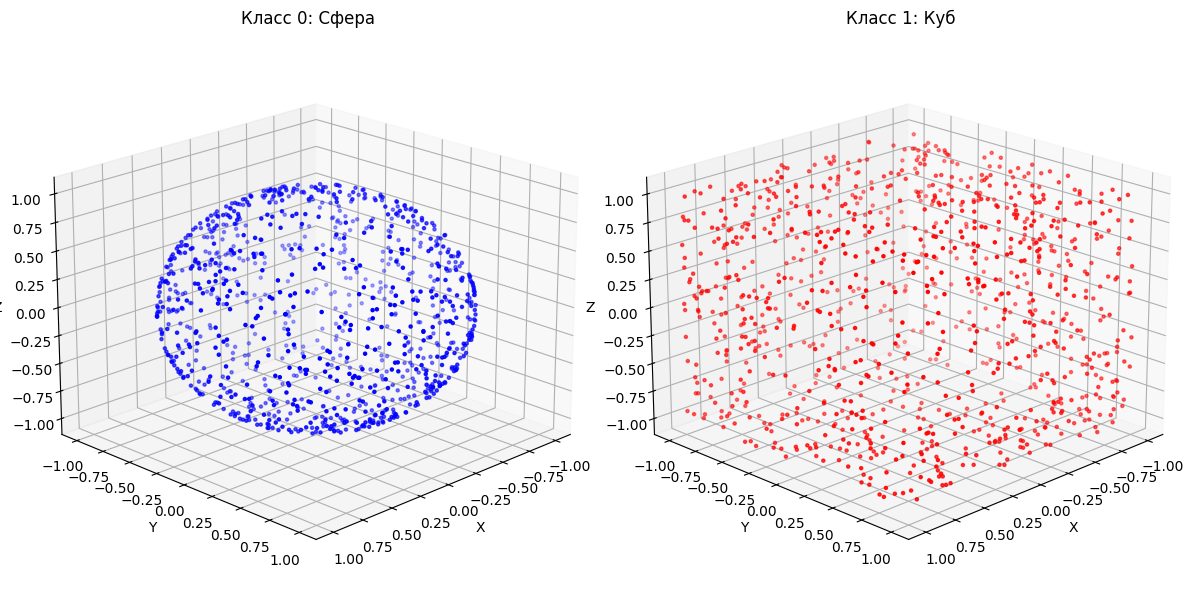

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from synthetic_pointcloud_dataset_2classes import gen_cloud_for_class

# Параметры
n_points = 1024
sphere_points = gen_cloud_for_class(0, n_points, sphere_surface=True)
cube_points = gen_cloud_for_class(1, n_points, cube_surface=True)

fig = plt.figure(figsize=(12, 6))

# Сфера
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(sphere_points[:, 0], sphere_points[:, 1], sphere_points[:, 2], s=5, c='blue')
ax1.set_title("Класс 0: Сфера")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=20, azim=45)

# Куб
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(cube_points[:, 0], cube_points[:, 1], cube_points[:, 2], s=5, c='red')
ax2.set_title("Класс 1: Куб")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()


In [14]:
"""
PointNet (Qi et al., CVPR 2017) — PyTorch Implementation (Classification)
=======================================================================

Этот файл содержит минималистичную, но практически полезную реализацию базовой архитектуры **PointNet**
для задачи классификации облаков точек. Он включает:

1. **T-Net** (input transform): регрессия матрицы преобразования размеров KxK (обычно 3x3 для входных XYZ).
2. **Feature Transform T-Net** (опционально): регрессия матрицы 64x64 для выравнивания признаков после первой MLP.
3. **Shared MLP**: реализовано как последовательность 1x1 Conv1d слоёв с BatchNorm и ReLU (эквивалентно точечным MLP, применённым независимо к каждой точке, но эффективно батчируется).
4. **Symmetric Aggregation**: глобальный max pooling по всем точкам -> глобальный вектор признаков.
5. **Классификатор**: полносвязная голова (MLP) 1024->512->256->num_classes с dropout.
6. **Регуляризатор ортогональности** для feature-transform матрицы из T-Net (см. раздел 5.2 в оригинальной статье).

---
## Использование
```python
import torch
from pointnet_architecture import PointNetClassifier

model = PointNetClassifier(num_classes=2, input_dim=3, feature_transform=True)
pts = torch.randn(8, 1024, 3)  # (B, N, 3)
logits, trans_mats = model(pts)  # logits: (B, num_classes)
loss_cls = torch.nn.functional.cross_entropy(logits, labels)
if trans_mats["feat"] is not None:
    loss_reg = feature_transform_regularizer(trans_mats["feat"])
    loss = loss_cls + 0.001 * loss_reg
else:
    loss = loss_cls
loss.backward()
```

---
## Форматы входов
* Ожидаем вход `x` формы **(B, N, C)** в формате batch-first.
* Внутри сети он транспонируется в **(B, C, N)** под слои Conv1d.

---
## Ссылки
* Qi, Charles R., et al. "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation." CVPR 2017.
* Официальный код автора (TensorFlow): github.com/charlesq34/pointnet.
* PyTorch порты (различные, см. PyTorchGeometric, Open3D-ML и др.).

---
Примечание: Это *reference-style* код, акцент на читаемости и ясности. Для production можно упростить / ускорить.
"""

from __future__ import annotations
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Optional, Tuple


# -----------------------------------------------------------------------------
# Utils
# -----------------------------------------------------------------------------

def knn(x: torch.Tensor, k: int) -> torch.Tensor:
    """(Не используется в базовом PointNet, но оставлено для расширений, напр. EdgeConv).
    Возвращает индексы k ближайших соседей по батчу.
    x: (B, C, N).
    """
    # pairwise distance: ||x_i - x_j||^2 = x^2 + x^2 - 2x^T x
    with torch.no_grad():
        B, C, N = x.shape
        xx = torch.sum(x ** 2, dim=1, keepdim=True)  # (B,1,N)
        dist = xx + xx.transpose(2, 1) - 2 * torch.matmul(x.transpose(2, 1), x)  # (B,N,N)
        _, idx = dist.topk(k=k, dim=-1, largest=False, sorted=False)  # (B,N,k)
    return idx


# -----------------------------------------------------------------------------
# T-Net: регрессия матрицы преобразования KxK
# -----------------------------------------------------------------------------

class TNet(nn.Module):
    def __init__(self, k: int = 3):
        super().__init__()
        self.k = k
        # Shared MLP: k -> 64 -> 128 -> 1024
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

        # FC: 1024 -> 512 -> 256 -> k*k
        self.fc1 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, k * k)

        # Инициализируем bias как единичную матрицу (flattened)
        self.init_bias_as_identity()

    def init_bias_as_identity(self):
        nn.init.zeros_(self.fc3.weight)
        ident = torch.eye(self.k).view(-1)
        with torch.no_grad():
            self.fc3.bias.copy_(ident)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, k, N)
        B = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, dim=2, keepdim=False)[0]  # (B,1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)  # (B, k*k)

        x = x.view(B, self.k, self.k)
        return x


# -----------------------------------------------------------------------------
# PointNet Encoder (input + feature transforms, shared MLP, global feature)
# -----------------------------------------------------------------------------

class PointNetEncoder(nn.Module):
    def __init__(self, global_feat: bool = True, feature_transform: bool = False, input_dim: int = 3):
        super().__init__()
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        self.input_dim = input_dim

        # Input transform
        self.input_tnet = TNet(k=input_dim)

        # Shared MLP: input_dim -> 64 -> 64
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)

        # Feature transform (64x64)
        if self.feature_transform:
            self.feature_tnet = TNet(k=64)
        else:
            self.feature_tnet = None

        # Shared MLP continued: 64 -> 64 -> 128 -> 1024
        self.conv3 = nn.Conv1d(64, 64, 1)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.bn4 = nn.BatchNorm1d(128)
        self.conv5 = nn.Conv1d(128, 1024, 1)
        self.bn5 = nn.BatchNorm1d(1024)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]:
        # x: (B, N, C)
        x = x.transpose(2, 1)  # -> (B, C, N)
        B = x.size(0)

        # ----- Input transform -----
        trans = self.input_tnet(x)  # (B,C,C)
        x = torch.bmm(trans, x)  # (B,C,N)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))  # now (B,64,N)

        if self.feature_transform:
            trans_feat = self.feature_tnet(x)  # (B,64,64)
            x = torch.bmm(trans_feat, x)
        else:
            trans_feat = None

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.bn5(self.conv5(x))  # (B,1024,N)

        x_max = torch.max(x, dim=2, keepdim=False)[0]  # (B,1024)

        if self.global_feat:
            return x_max, trans, trans_feat  # только глобальная фича
        else:
            # Конкатенируем глобальную фичу к каждой точке (для сегментации)
            B, _, N = x.shape
            x_global_expanded = x_max.unsqueeze(-1).repeat(1, 1, N)  # (B,1024,N)
            feat = torch.cat([x, x_global_expanded], dim=1)  # (B,1024+1024,N)= (B,2048,N)
            return feat, trans, trans_feat


# -----------------------------------------------------------------------------
# Классификатор поверх PointNet Encoder
# -----------------------------------------------------------------------------

class PointNetClassifier(nn.Module):
    def __init__(self, num_classes: int, input_dim: int = 3, feature_transform: bool = False, dropout: float = 0.3):
        super().__init__()
        self.num_classes = num_classes
        self.feature_transform = feature_transform
        self.feat = PointNetEncoder(global_feat=True, feature_transform=feature_transform, input_dim=input_dim)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, Optional[torch.Tensor]]]:
        # x: (B,N,C)
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return x, {"input": trans, "feat": trans_feat}


# -----------------------------------------------------------------------------
# Регуляризатор ортогональности для feature transform
# -----------------------------------------------------------------------------

def feature_transform_regularizer(trans: torch.Tensor) -> torch.Tensor:
    """L2-норма отклонения от ортогональности: ||I - A A^T||_F^2 / (2).
    trans: (B, K, K).
    Возвращает скалярный тензор.
    """
    B, K, _ = trans.size()
    I = torch.eye(K, device=trans.device).unsqueeze(0).expand(B, -1, -1)
    diff = torch.bmm(trans, trans.transpose(2, 1)) - I
    loss = torch.mean(torch.sum(diff ** 2, dim=(1, 2)))
    return loss


# -----------------------------------------------------------------------------
# Быстрый smoke-test
# -----------------------------------------------------------------------------

if __name__ == "__main__":
    B, N, C = 4, 1024, 3
    dummy = torch.randn(B, N, C)
    labels = torch.randint(0, 2, (B,))

    model = PointNetClassifier(num_classes=2, input_dim=C, feature_transform=True)
    logits, trans_dict = model(dummy)
    print("logits", logits.shape)
    print("input trans", trans_dict["input"].shape)
    print("feat trans", None if trans_dict["feat"] is None else trans_dict["feat"].shape)

    loss_cls = F.cross_entropy(logits, labels)
    if trans_dict["feat"] is not None:
        loss_reg = feature_transform_regularizer(trans_dict["feat"])
        loss = loss_cls + 0.001 * loss_reg
    else:
        loss = loss_cls
    loss.backward()
    print("loss", float(loss))


logits torch.Size([4, 2])
input trans torch.Size([4, 3, 3])
feat trans torch.Size([4, 64, 64])
loss 0.8418786525726318


In [15]:
"""
Train PointNet on Synthetic Sphere-vs-Cube Point-Cloud Dataset
==============================================================

Самодостаточный учебный скрипт:
- Генерирует синтетический датасет (2 класса: сфера и куб).
- Создаёт PyTorch DataLoader'ы.
- Строит модель PointNet (классификация) с optional feature transform.
- Обучает, валидирует, тестирует.

Зачем отдельный файл? Чтобы вы могли сразу запустить обучение без ручной сборки окружения.
Если у вас уже есть модуль `synthetic_pointcloud_dataset_2classes.py` и `pointnet_architecture.py`,
вы можете импортировать их вместо локальных реализаций ниже: см. блок "# --- Import override hooks ---".

Быстрый старт (Jupyter):
------------------------
```python
!pip install torch torchvision --quiet  # если не установлено

# При необходимости: !pip install --quiet numpy

import train_pointnet_on_sphere_cube as tp

cfg = tp.TrainConfig(
    n_train=2000,
    n_val=400,
    n_test=400,
    n_points=1024,
    sphere_surface=True,
    cube_surface=True,
    noise_std=0.0,              # базовый шум при генерации (аугмент ниже)
    aug_noise_std=0.005,
    aug_rotate=True,
    aug_scale=(0.9, 1.1),
    aug_translate=0.05,
    feature_transform=True,
    batch_size=32,
    epochs=20,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seed=42,
)

results = tp.train_pointnet(cfg)
print("Best val acc:", results["best_val_acc"])
print("Test acc:", results["test_acc"])
```

CLI (как скрипт):
-----------------
```bash
python train_pointnet_on_sphere_cube.py --device cuda --epochs 20 --feature_transform \
  --n_train 2000 --n_val 400 --n_test 400 --n_points 1024 --aug_noise_std 0.005 --aug_rotate \
  --aug_scale_lo 0.9 --aug_scale_hi 1.1 --aug_translate 0.05
```

"""

from __future__ import annotations
import os
import sys
import math
import json
import random
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ==============================================================================================
# --- Import override hooks --------------------------------------------------------------------
# ==============================================================================================
# Если у вас есть внешние файлы с полной реализацией, раскомментируйте и используйте их:
# from synthetic_pointcloud_dataset_2classes import generate_arrays, SyntheticPointCloudDataset, AugmentCfg
# from pointnet_architecture import PointNetClassifier, feature_transform_regularizer
# В данном файле мы включаем минимальные локальные версии ниже, чтобы скрипт работал "из коробки".

# ==============================================================================================
# 1. Мини‑версия синтетического датасета (Sphere vs Cube)
# ==============================================================================================

def _rand_normals(n: int) -> np.ndarray:
    v = np.random.normal(size=(n, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True) + 1e-12
    return v.astype(np.float32)


def sample_sphere(n_points: int, radius: float = 1.0, surface: bool = True) -> np.ndarray:
    dirs = _rand_normals(n_points)
    if surface:
        r = np.full((n_points, 1), radius, dtype=np.float32)
    else:
        u = np.random.rand(n_points, 1).astype(np.float32)
        r = radius * (u ** (1.0 / 3.0))
    return (dirs * r).astype(np.float32)


def sample_cube(n_points: int, half_extent: float = 1.0, surface: bool = True) -> np.ndarray:
    if surface:
        pts = np.zeros((n_points, 3), dtype=np.float32)
        faces = np.random.randint(0, 6, size=n_points)
        uv = np.random.rand(n_points, 2).astype(np.float32) * 2 * half_extent - half_extent
        for i in range(n_points):
            f = faces[i]; u,v = uv[i]
            if f == 0:   pts[i] = [ half_extent, u, v]
            elif f == 1: pts[i] = [-half_extent, u, v]
            elif f == 2: pts[i] = [u,  half_extent, v]
            elif f == 3: pts[i] = [u, -half_extent, v]
            elif f == 4: pts[i] = [u, v,  half_extent]
            elif f == 5: pts[i] = [u, v, -half_extent]
        return pts
    else:
        return (np.random.rand(n_points,3).astype(np.float32)*2*half_extent - half_extent).astype(np.float32)


# ----------------- Аугментации -----------------

def _rotmat_random() -> np.ndarray:
    # случайный кватернион -> матрица вращения
    u1, u2, u3 = np.random.rand(3)
    q1 = math.sqrt(1 - u1) * math.sin(2 * math.pi * u2)
    q2 = math.sqrt(1 - u1) * math.cos(2 * math.pi * u2)
    q3 = math.sqrt(u1) * math.sin(2 * math.pi * u3)
    q4 = math.sqrt(u1) * math.cos(2 * math.pi * u3)
    x,y,z,w = q1,q2,q3,q4
    R = np.array([
        [1 - 2*(y*y + z*z), 2*(x*y - z*w),     2*(x*z + y*w)],
        [2*(x*y + z*w),     1 - 2*(x*x + z*z), 2*(y*z - x*w)],
        [2*(x*z - y*w),     2*(y*z + x*w),     1 - 2*(x*x + y*y)],
    ], dtype=np.float32)
    return R


def _apply_rot(pts: np.ndarray, R: np.ndarray) -> np.ndarray:
    return (pts @ R.T).astype(np.float32)


def _apply_scale(pts: np.ndarray, s: float) -> np.ndarray:
    return (pts * s).astype(np.float32)


def _apply_trans(pts: np.ndarray, t: np.ndarray) -> np.ndarray:
    return (pts + t.reshape(1,3)).astype(np.float32)


def _apply_noise(pts: np.ndarray, std: float) -> np.ndarray:
    if std <= 0: return pts
    return (pts + np.random.normal(scale=std, size=pts.shape).astype(np.float32)).astype(np.float32)


class AugmentCfg:
    def __init__(self,
                 noise_std: float = 0.0,
                 random_rotate: bool = False,
                 random_scale_range: Optional[Tuple[float,float]] = None,
                 random_translate_range: Optional[float] = None):
        self.noise_std = noise_std
        self.random_rotate = random_rotate
        self.random_scale_range = random_scale_range
        self.random_translate_range = random_translate_range
    def apply(self, pts: np.ndarray) -> np.ndarray:
        if self.random_rotate:
            pts = _apply_rot(pts, _rotmat_random())
        if self.random_scale_range is not None:
            lo,hi = self.random_scale_range
            pts = _apply_scale(pts, np.random.uniform(lo,hi))
        if self.random_translate_range is not None:
            tr = np.random.uniform(-self.random_translate_range, self.random_translate_range, size=(3,)).astype(np.float32)
            pts = _apply_trans(pts, tr)
        pts = _apply_noise(pts, self.noise_std)
        return pts


def _gen_cloud(cls:int, n_points:int, sphere_surface:bool, cube_surface:bool,
               noise_std:float, random_rotate:bool,
               random_scale_range:Optional[Tuple[float,float]],
               random_translate_range:Optional[float]) -> np.ndarray:
    if cls==0:
        pts = sample_sphere(n_points, surface=sphere_surface)
    elif cls==1:
        pts = sample_cube(n_points, surface=cube_surface)
    else:
        raise ValueError
    # базовые аугментации генерации (что указано в аргументах)
    if random_rotate:
        pts = _apply_rot(pts, _rotmat_random())
    if random_scale_range is not None:
        lo,hi = random_scale_range
        pts = _apply_scale(pts, np.random.uniform(lo,hi))
    if random_translate_range is not None:
        tr = np.random.uniform(-random_translate_range, random_translate_range, size=(3,)).astype(np.float32)
        pts = _apply_trans(pts, tr)
    pts = _apply_noise(pts, noise_std)
    return pts


def generate_arrays(n_per_class:int,
                    n_points:int=1024,
                    sphere_surface:bool=True,
                    cube_surface:bool=True,
                    noise_std:float=0.0,
                    random_rotate:bool=False,
                    random_scale_range:Optional[Tuple[float,float]]=None,
                    random_translate_range:Optional[float]=None,
                    shuffle:bool=True):
    total = 2*n_per_class
    X = np.zeros((total,n_points,3),dtype=np.float32)
    y = np.zeros((total,),dtype=np.int64)
    idx=0
    for cls in (0,1):
        for _ in range(n_per_class):
            X[idx] = _gen_cloud(cls,n_points,sphere_surface,cube_surface,noise_std,random_rotate,random_scale_range,random_translate_range)
            y[idx] = cls
            idx+=1
    if shuffle:
        perm = np.random.permutation(total)
        X = X[perm]; y = y[perm]
    return X,y


class SyntheticPointCloudDataset(Dataset):
    def __init__(self, X:np.ndarray, y:np.ndarray, augment:Optional[AugmentCfg]=None, device:Optional[str]=None):
        self.X = X
        self.y = y.astype(np.int64)
        self.augment = augment
        self.device = torch.device(device) if (device is not None) else None
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx:int):
        pts = self.X[idx]
        if self.augment is not None:
            pts = self.augment.apply(pts.copy())
        pts_t = torch.from_numpy(pts)           # (N,3)
        label_t = torch.tensor(self.y[idx])
        if self.device is not None:
            pts_t = pts_t.to(self.device)
            label_t = label_t.to(self.device)
        return pts_t, label_t


# ==============================================================================================
# 2. Мини‑PointNet (классификация)
# ==============================================================================================

class TNet(nn.Module):
    def __init__(self, k:int=3):
        super().__init__()
        self.k=k
        self.conv1=nn.Conv1d(k,64,1); self.bn1=nn.BatchNorm1d(64)
        self.conv2=nn.Conv1d(64,128,1); self.bn2=nn.BatchNorm1d(128)
        self.conv3=nn.Conv1d(128,1024,1); self.bn3=nn.BatchNorm1d(1024)
        self.fc1=nn.Linear(1024,512); self.bn4=nn.BatchNorm1d(512)
        self.fc2=nn.Linear(512,256); self.bn5=nn.BatchNorm1d(256)
        self.fc3=nn.Linear(256,k*k)
        self._init_bias_identity()
    def _init_bias_identity(self):
        nn.init.zeros_(self.fc3.weight)
        with torch.no_grad():
            self.fc3.bias.copy_(torch.eye(self.k).view(-1))
    def forward(self,x):
        # x: (B,k,N)
        b=x.size(0)
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        x=F.relu(self.bn3(self.conv3(x)))
        x=torch.max(x,2)[0]  # (B,1024)
        x=F.relu(self.bn4(self.fc1(x)))
        x=F.relu(self.bn5(self.fc2(x)))
        x=self.fc3(x)
        x=x.view(b,self.k,self.k)
        return x


class PointNetEncoder(nn.Module):
    def __init__(self, input_dim:int=3, feature_transform:bool=False):
        super().__init__()
        self.input_dim=input_dim
        self.feature_transform=feature_transform
        self.input_tnet=TNet(k=input_dim)
        self.conv1=nn.Conv1d(input_dim,64,1); self.bn1=nn.BatchNorm1d(64)
        self.conv2=nn.Conv1d(64,64,1); self.bn2=nn.BatchNorm1d(64)
        if feature_transform:
            self.feature_tnet=TNet(k=64)
        else:
            self.feature_tnet=None
        self.conv3=nn.Conv1d(64,64,1); self.bn3=nn.BatchNorm1d(64)
        self.conv4=nn.Conv1d(64,128,1); self.bn4=nn.BatchNorm1d(128)
        self.conv5=nn.Conv1d(128,1024,1); self.bn5=nn.BatchNorm1d(1024)
    def forward(self,x):
        # x: (B,N,C)
        x=x.transpose(2,1) # -> (B,C,N)
        trans=self.input_tnet(x)
        x=torch.bmm(trans,x)
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x))) # (B,64,N)
        trans_feat=None
        if self.feature_transform:
            trans_feat=self.feature_tnet(x)
            x=torch.bmm(trans_feat,x)
        x=F.relu(self.bn3(self.conv3(x)))
        x=F.relu(self.bn4(self.conv4(x)))
        x=self.bn5(self.conv5(x))
        x=torch.max(x,2)[0] # (B,1024)
        return x,trans,trans_feat


class PointNetClassifier(nn.Module):
    def __init__(self,num_classes:int,input_dim:int=3,feature_transform:bool=False,dropout:float=0.3):
        super().__init__()
        self.feature_transform=feature_transform
        self.feat=PointNetEncoder(input_dim=input_dim,feature_transform=feature_transform)
        self.fc1=nn.Linear(1024,512); self.bn1=nn.BatchNorm1d(512)
        self.fc2=nn.Linear(512,256); self.bn2=nn.BatchNorm1d(256)
        self.dp=nn.Dropout(dropout)
        self.fc3=nn.Linear(256,num_classes)
    def forward(self,x):
        # x: (B,N,C)
        x,trans,trans_feat=self.feat(x)
        x=F.relu(self.bn1(self.fc1(x)))
        x=F.relu(self.bn2(self.dp(self.fc2(x))))
        x=self.fc3(x)
        return x,{"input":trans,"feat":trans_feat}


def feature_transform_regularizer(trans:torch.Tensor)->torch.Tensor:
    # trans: (B,K,K)
    b,k,_=trans.size()
    I=torch.eye(k,device=trans.device).unsqueeze(0).expand(b,-1,-1)
    diff=torch.bmm(trans,trans.transpose(2,1))-I
    return torch.mean(torch.sum(diff**2,dim=(1,2)))


# ==============================================================================================
# 3. Конфигурация обучения
# ==============================================================================================

@dataclass
class TrainConfig:
    # Данные
    n_train:int=2000
    n_val:int=400
    n_test:int=400
    n_points:int=1024
    sphere_surface:bool=True
    cube_surface:bool=True
    noise_std:float=0.0              # базовый шум при генерации массивов
    # runtime аугментации (train)
    aug_noise_std:float=0.005
    aug_rotate:bool=True
    aug_scale:Optional[Tuple[float,float]]=(0.9,1.1)
    aug_translate:Optional[float]=0.05
    # модель
    feature_transform:bool=True
    dropout:float=0.3
    # обучение
    batch_size:int=32
    epochs:int=20
    lr:float=1e-3
    weight_decay:float=0.0
    ft_reg_weight:float=1e-3         # множитель регуляризатора feature transform
    # misc
    device:str="cpu"
    seed:int=42
    num_workers:int=0
    pin_memory:bool=False


# ==============================================================================================
# 4. Создание DataLoader'ов
# ==============================================================================================

def create_datasets(cfg:TrainConfig, device:Optional[str]=None):
    # device для тензоров, если None -> cfg.device
    device = device or cfg.device

    # Train / Val / Test генерируем независимо (можно сделать общий и разделить)
    Xtr,Ytr = generate_arrays(n_per_class=cfg.n_train//2, n_points=cfg.n_points,
                              sphere_surface=cfg.sphere_surface,cube_surface=cfg.cube_surface,
                              noise_std=cfg.noise_std,random_rotate=False,random_scale_range=None,
                              random_translate_range=None,shuffle=True)
    Xva,Yva = generate_arrays(n_per_class=cfg.n_val//2,   n_points=cfg.n_points,
                              sphere_surface=cfg.sphere_surface,cube_surface=cfg.cube_surface,
                              noise_std=0.0,random_rotate=False,random_scale_range=None,
                              random_translate_range=None,shuffle=True)
    Xte,Yte = generate_arrays(n_per_class=cfg.n_test//2,   n_points=cfg.n_points,
                              sphere_surface=cfg.sphere_surface,cube_surface=cfg.cube_surface,
                              noise_std=0.0,random_rotate=False,random_scale_range=None,
                              random_translate_range=None,shuffle=True)

    aug_train = AugmentCfg(noise_std=cfg.aug_noise_std, random_rotate=cfg.aug_rotate,
                           random_scale_range=cfg.aug_scale, random_translate_range=cfg.aug_translate)
    aug_eval  = AugmentCfg(noise_std=0.0, random_rotate=False, random_scale_range=None, random_translate_range=None)

    ds_tr = SyntheticPointCloudDataset(Xtr,Ytr,augment=aug_train,device=device)
    ds_va = SyntheticPointCloudDataset(Xva,Yva,augment=aug_eval, device=device)
    ds_te = SyntheticPointCloudDataset(Xte,Yte,augment=aug_eval, device=device)
    return ds_tr,ds_va,ds_te


def create_loaders(cfg:TrainConfig):
    ds_tr,ds_va,ds_te = create_datasets(cfg)
    # DataLoader: поскольку точки уже на device внутри __getitem__, batch_collate прост.
    # Однако PyTorch предпочитает перенос на device после коллации; мы оставляем как есть для наглядности.
    def _collate(batch):
        pts_list, lbl_list = zip(*batch) # list len B; pts_i:(N,3)
        pts = torch.stack(pts_list,dim=0)  # (B,N,3)
        lbl = torch.stack(lbl_list,dim=0)  # (B,)
        return pts, lbl

    tr_loader = DataLoader(ds_tr,batch_size=cfg.batch_size,shuffle=True,num_workers=cfg.num_workers,
                           pin_memory=cfg.pin_memory,collate_fn=_collate)
    va_loader = DataLoader(ds_va,batch_size=cfg.batch_size,shuffle=False,num_workers=cfg.num_workers,
                           pin_memory=cfg.pin_memory,collate_fn=_collate)
    te_loader = DataLoader(ds_te,batch_size=cfg.batch_size,shuffle=False,num_workers=cfg.num_workers,
                           pin_memory=cfg.pin_memory,collate_fn=_collate)
    return tr_loader,va_loader,te_loader


# ==============================================================================================
# 5. Метрики
# ==============================================================================================

def accuracy_from_logits(logits:torch.Tensor, labels:torch.Tensor)->float:
    preds = logits.argmax(dim=1)
    correct = (preds==labels).float().sum()
    return float(correct/labels.numel())


# ==============================================================================================
# 6. Основной цикл обучения
# ==============================================================================================

def train_pointnet(cfg:TrainConfig)->Dict[str,Any]:
    set_seed(cfg.seed)
    device = torch.device(cfg.device)

    tr_loader,va_loader,te_loader = create_loaders(cfg)

    model = PointNetClassifier(num_classes=2,input_dim=3,feature_transform=cfg.feature_transform,dropout=cfg.dropout)
    model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = None  # можно добавить StepLR / Cosine

    best_val_acc = 0.0
    best_state = None

    for epoch in range(1,cfg.epochs+1):
        model.train(); running_loss=0.0; running_acc=0.0; n_batches=0
        for pts,lbl in tr_loader:
            # Если в Dataset device уже применён, перенос может быть не нужен
            pts=pts.to(device)
            lbl=lbl.to(device)
            opt.zero_grad()
            logits,trans_dict = model(pts)
            loss_cls = F.cross_entropy(logits,lbl)
            loss = loss_cls
            if cfg.feature_transform and (trans_dict["feat"] is not None):
                loss_reg = feature_transform_regularizer(trans_dict["feat"])
                loss = loss + cfg.ft_reg_weight * loss_reg
            loss.backward(); opt.step()
            running_loss += float(loss)*pts.size(0)
            running_acc  += accuracy_from_logits(logits.detach(),lbl)*pts.size(0)
            n_batches += pts.size(0)
        train_loss = running_loss/n_batches
        train_acc  = running_acc/n_batches

        val_loss,val_acc = evaluate(model,va_loader,device,cfg)
        if scheduler is not None: scheduler.step()

        if val_acc>best_val_acc:
            best_val_acc=val_acc
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}

        print(f"Epoch {epoch:03d}/{cfg.epochs} | train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f}")

    # Load best
    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss,test_acc = evaluate(model,te_loader,device,cfg)
    print(f"Test  | loss={test_loss:.4f} acc={test_acc:.4f}")

    return {
        "model":model,
        "best_val_acc":best_val_acc,
        "test_acc":test_acc,
    }


def evaluate(model:PointNetClassifier, loader:DataLoader, device, cfg:TrainConfig)->Tuple[float,float]:
    model.eval(); running_loss=0.0; running_acc=0.0; n_samples=0
    with torch.no_grad():
        for pts,lbl in loader:
            pts=pts.to(device); lbl=lbl.to(device)
            logits,trans_dict = model(pts)
            loss_cls = F.cross_entropy(logits,lbl)
            loss = loss_cls
            if cfg.feature_transform and (trans_dict["feat"] is not None):
                loss += cfg.ft_reg_weight * feature_transform_regularizer(trans_dict["feat"])
            running_loss += float(loss)*pts.size(0)
            running_acc  += accuracy_from_logits(logits,lbl)*pts.size(0)
            n_samples += pts.size(0)
    return running_loss/n_samples, running_acc/n_samples


# ==============================================================================================
# 7. Утилиты
# ==============================================================================================

def set_seed(seed:int=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ==============================================================================================
# 8. CLI
# ==============================================================================================

def cli_main(argv=None):
    import argparse
    p = argparse.ArgumentParser(description="Train PointNet on synthetic Sphere-vs-Cube dataset",formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    p.add_argument("--n_train",type=int,default=2000)
    p.add_argument("--n_val",type=int,default=400)
    p.add_argument("--n_test",type=int,default=400)
    p.add_argument("--n_points",type=int,default=1024)
    p.add_argument("--sphere_surface",action="store_true")
    p.add_argument("--cube_surface",action="store_true")
    p.add_argument("--noise_std",type=float,default=0.0)
    p.add_argument("--aug_noise_std",type=float,default=0.005)
    p.add_argument("--aug_rotate",action="store_true")
    p.add_argument("--aug_scale_lo",type=float,default=None)
    p.add_argument("--aug_scale_hi",type=float,default=None)
    p.add_argument("--aug_translate",type=float,default=None)
    p.add_argument("--feature_transform",action="store_true")
    p.add_argument("--dropout",type=float,default=0.3)
    p.add_argument("--batch_size",type=int,default=32)
    p.add_argument("--epochs",type=int,default=20)
    p.add_argument("--lr",type=float,default=1e-3)
    p.add_argument("--weight_decay",type=float,default=0.0)
    p.add_argument("--ft_reg_weight",type=float,default=1e-3)
    p.add_argument("--device",type=str,default="cuda" if torch.cuda.is_available() else "cpu")
    p.add_argument("--seed",type=int,default=42)

    args,unknown = p.parse_known_args(argv)
    if unknown:
        print("[warn] Ignoring unknown args:",unknown)

    aug_scale=None
    if (args.aug_scale_lo is not None) and (args.aug_scale_hi is not None):
        aug_scale=(args.aug_scale_lo,args.aug_scale_hi)

    cfg = TrainConfig(
        n_train=args.n_train,
        n_val=args.n_val,
        n_test=args.n_test,
        n_points=args.n_points,
        sphere_surface=args.sphere_surface,
        cube_surface=args.cube_surface,
        noise_std=args.noise_std,
        aug_noise_std=args.aug_noise_std,
        aug_rotate=args.aug_rotate,
        aug_scale=aug_scale,
        aug_translate=args.aug_translate,
        feature_transform=args.feature_transform,
        dropout=args.dropout,
        batch_size=args.batch_size,
        epochs=args.epochs,
        lr=args.lr,
        weight_decay=args.weight_decay,
        ft_reg_weight=args.ft_reg_weight,
        device=args.device,
        seed=args.seed,
    )

    print("Config:",cfg)
    return train_pointnet(cfg)


# ==============================================================================================
# 9. Script entry
# ==============================================================================================

if __name__ == "__main__":
    cli_main(sys.argv[1:])


[warn] Ignoring unknown args: ['-f', '/root/.local/share/jupyter/runtime/kernel-ffda61ea-3927-4991-96ab-26c969593122.json']
Config: TrainConfig(n_train=2000, n_val=400, n_test=400, n_points=1024, sphere_surface=False, cube_surface=False, noise_std=0.0, aug_noise_std=0.005, aug_rotate=False, aug_scale=None, aug_translate=None, feature_transform=False, dropout=0.3, batch_size=32, epochs=20, lr=0.001, weight_decay=0.0, ft_reg_weight=0.001, device='cpu', seed=42, num_workers=0, pin_memory=False)
Epoch 001/20 | train_loss=0.0226 acc=0.9930 | val_loss=0.0046 acc=1.0000
Epoch 002/20 | train_loss=0.0014 acc=1.0000 | val_loss=0.0021 acc=1.0000
Epoch 003/20 | train_loss=0.0009 acc=1.0000 | val_loss=0.0013 acc=1.0000


KeyboardInterrupt: 